<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-vector-dataset" data-toc-modified-id="Input-vector-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Input vector dataset</a></span><ul class="toc-item"><li><span><a href="#From-a-GeoJSON-string" data-toc-modified-id="From-a-GeoJSON-string-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>From a GeoJSON string</a></span></li><li><span><a href="#From-a-zipped-ESRI-Shapefile" data-toc-modified-id="From-a-zipped-ESRI-Shapefile-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>From a zipped ESRI Shapefile</a></span></li></ul></li><li><span><a href="#Vector-coverage" data-toc-modified-id="Vector-coverage-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Vector coverage</a></span><ul class="toc-item"><li><span><a href="#Spatial-reference-system" data-toc-modified-id="Spatial-reference-system-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Spatial reference system</a></span></li><li><span><a href="#Geographic-coordinates" data-toc-modified-id="Geographic-coordinates-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Geographic coordinates</a></span></li><li><span><a href="#Plot-polygon-with-matplotlib" data-toc-modified-id="Plot-polygon-with-matplotlib-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot polygon with <code>matplotlib</code></a></span></li></ul></li><li><span><a href="#Identify-granules-(CMR-Search)" data-toc-modified-id="Identify-granules-(CMR-Search)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Identify granules (CMR Search)</a></span><ul class="toc-item"><li><span><a href="#Collection" data-toc-modified-id="Collection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Collection</a></span></li><li><span><a href="#Granules" data-toc-modified-id="Granules-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Granules</a></span></li></ul></li><li><span><a href="#Retrieve-data-(Harmony-API)" data-toc-modified-id="Retrieve-data-(Harmony-API)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Retrieve data (Harmony API)</a></span><ul class="toc-item"><li><span><a href="#Assemble-the-request-url" data-toc-modified-id="Assemble-the-request-url-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Assemble the request url</a></span></li><li><span><a href="#Download,-open-in-Python" data-toc-modified-id="Download,-open-in-Python-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Download, open in Python</a></span><ul class="toc-item"><li><span><a href="#with-netCDF4" data-toc-modified-id="with-netCDF4-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>with <code>netCDF4</code></a></span></li><li><span><a href="#with-xarray" data-toc-modified-id="with-xarray-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>with <code>xarray</code></a></span></li></ul></li><li><span><a href="#Plot-sea_surface_temperature" data-toc-modified-id="Plot-sea_surface_temperature-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Plot <code>sea_surface_temperature</code></a></span></li></ul></li><li><span><a href="#Mask-output-SST-variable" data-toc-modified-id="Mask-output-SST-variable-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Mask output SST variable</a></span><ul class="toc-item"><li><span><a href="#Affine-GeoTransform" data-toc-modified-id="Affine-GeoTransform-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Affine GeoTransform</a></span></li><li><span><a href="#Rasterize-polygon-to-mask" data-toc-modified-id="Rasterize-polygon-to-mask-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Rasterize polygon to mask</a></span></li><li><span><a href="#Add-mask-to-output-dataset" data-toc-modified-id="Add-mask-to-output-dataset-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Add mask to output dataset</a></span></li><li><span><a href="#Apply-the-mask" data-toc-modified-id="Apply-the-mask-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Apply the mask</a></span></li></ul></li><li><span><a href="#Process-a-series-(WIP)" data-toc-modified-id="Process-a-series-(WIP)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Process a series (<code>WIP</code>)</a></span></li></ul></div>

# Get SST on projected grid via Harmony, apply polygon mask

This notebook started as a fvalidate the outputs from Mike's demo notebook here:     
https://github.com/podaac/tutorials/blob/master/notebooks/l2-regridding/reprojection%20notebook.md

I was interested in this part, specifically:       
https://github.com/podaac/tutorials/blob/master/notebooks/l2-regridding/reprojection%20notebook.md#access-level-2-swath-regridded-data

**Run the snippet below to authenticate with your Earthdata account:**

In [1]:
from urllib import request, parse
from http.cookiejar import CookieJar
import getpass
import netrc


def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them. 
    
    Valid endpoints include:
      
      uat.urs.earthdata.nasa.gov: Earthdata Login UAT (Harmony's current default)
      urs.earthdata.nasa.gov:     Earthdata Login production

    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    

setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

Import json, GDAL/OGR/OSR, and numpy.

In [2]:
from urllib import request
from datetime import datetime
from json import loads, dumps
from osgeo import gdal, ogr, osr
from netCDF4 import Dataset
from pandas import DataFrame
import numpy as np

# Enable exceptions for GDAL API.
gdal.UseExceptions()

# Disallow scientific notation printing numpy arrays:
np.set_printoptions(suppress=True)

## Input vector dataset

We'll use the familiar Gulf of Mexico (GOM) polgon as a study area. This section creates a vector dataset from a GeoJSON string, and also gives the logic to open the vector dataset from a zipped ESRI Shapefile included in the repo.

### From a GeoJSON string

In [3]:
gom_json = '''{
  "type": "Polygon",
  "coordinates": [
    [
      [
        325978.49868962413,
        -1212360.0996774102
      ],
      [
        1127068.6891959498,
        -1072904.1792679257
      ],
      [
        1482582.5983730783,
        -1630510.338182519
      ],
      [
        1167671.3479267422,
        -2074457.6943755634
      ],
      [
        688889.4434175839,
        -2154590.9632218685
      ],
      [
        522340.62870002043,
        -2371429.169580494
      ],
      [
        -21580.709364385264,
        -2378167.598829381
      ],
      [
        -194204.2314713869,
        -1950877.245632191
      ],
      [
        -108138.15410657249,
        -1451018.2786152344
      ],
      [
        325978.49868962413,
        -1212360.0996774102
      ]
    ]
  ]
}
'''

The coordinates are in albers equal area conic projected meters:

In [4]:
gom_proj = "+proj=aea +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

Get the proj4 string in the `properties.crs` and import it to a new `osr.SpatialReference` object:

In [5]:
# Create a new Spatial Reference object:
srs = osr.SpatialReference()

# Import the Proj4 string to the new SRS:
srs.ImportFromProj4(gom_proj)

print(srs.ExportToPrettyWkt())

PROJCS["unknown",
    GEOGCS["unknown",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["latitude_of_center",40],
    PARAMETER["longitude_of_center",-96],
    PARAMETER["standard_parallel_1",20],
    PARAMETER["standard_parallel_2",60],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]


Sometimes OGR makes you work to accomplish seemingly simple tasks, like making a new vector dataset. 

Create an OGR vector dataset from the GeoJSON string in several steps:

1. Use the `MEMORY` driver to create a new OGR vector data source called `gom`.

In [6]:
driver = ogr.GetDriverByName("MEMORY")

gom = driver.CreateDataSource("MemoryDataset")

2. Create a new polygon `ogr.Layer` in the vector data source.
  * Define the `ID` field.
  * Add it to the layer.

In [7]:
lyr = gom.CreateLayer("Gulf_of_Mexico", srs, geom_type=ogr.wkbPolygon)

lid = ogr.FieldDefn("ID", ogr.OFTInteger)
lyr.CreateField(lid)

0

3. Get the layer definition - the schema describing its fields - and create a new `ogr.Feature` the follows the schema requirements:

In [8]:
featdefn = lyr.GetLayerDefn()

feat = ogr.Feature(featdefn)

4. Create an `ogr.Geometry` from the input GeoJSON string and add it to the new feature. Then, set the value of the `ID` field for the new feature:

In [9]:
geom = ogr.CreateGeometryFromJson(gom_json)

feat.SetGeometry(geom)
feat.SetField("ID", 1)

5. Add the feature to the layer. Then, dereference the feature object.

In [10]:
lyr.CreateFeature(feat)

feat = None

### From a zipped ESRI Shapefile

These steps grab the same polygon feature from a zipped ESRI Shapefile, and should work for most OGR-compatible vector dataset:

```python
shp = "/vsizip/resources/gulf_shapefile_102008.zip/gulf_shapefile_102008.shp"

shp = ogr.Open(shp)            # Open ESRI Shapefile (or other vector).
lyr = shp.GetLayer()           # Get first (and only) layer.
feat = lyr.GetFeature(0)       # Get layer's only feature.
geom = feat.GetGeometryRef()   # Get feature's geometry.
```

The prefix `/vsizip/` is added to instruct GDAL to look inside the zip for the target ESRI Shapefile.

## Vector coverage

Get the rectangular extent of the geometry:

In [11]:
ext = lyr.GetExtent()

ext

(-194204.2314713869,
 1482582.5983730783,
 -2378167.598829381,
 -1072904.1792679257)

(Assume the user loaded the vector dataset from a file.) Get the polygon geometry as a GeoJSON string and load it to a Python dictionary. Then, print the coordinates:

In [12]:
poly = loads(geom.ExportToJson())

print(dumps(poly['coordinates'], indent=2))

[
  [
    [
      325978.49868962413,
      -1212360.0996774102
    ],
    [
      1127068.6891959498,
      -1072904.1792679257
    ],
    [
      1482582.5983730783,
      -1630510.338182519
    ],
    [
      1167671.3479267422,
      -2074457.6943755634
    ],
    [
      688889.4434175839,
      -2154590.9632218685
    ],
    [
      522340.62870002043,
      -2371429.169580494
    ],
    [
      -21580.709364385264,
      -2378167.598829381
    ],
    [
      -194204.2314713869,
      -1950877.245632191
    ],
    [
      -108138.15410657249,
      -1451018.2786152344
    ],
    [
      325978.49868962413,
      -1212360.0996774102
    ]
  ]
]


### Spatial reference system

The spatial reference module (`osr`) provides access to projection parameters and common geospatial transforms used by the GDAL API. 

This grabs the EPSG from any GDAL/OGR supported vector/raster dataset, if it exists. If it doesn't have an EPSG, `AutoIdentifyEPSG` will try to predict the EPSG based on other available projection parameters:

In [13]:
# Get the 'osr.SpatialReference' from the OGR Layer.
ssrs = lyr.GetSpatialRef()

# Try to look up an EPSG for the SRS object.
ssrs.AutoIdentifyEPSG()

# Get highest authority EPSG code (authority=None):
epsg = ssrs.GetAuthorityCode(None)

f"EPSG:{epsg}"

'EPSG:None'

You have access to several other representations of the vector dataset's SRS through the methods provided by the `osr.SpatialReference` object:

```python
> dir(srs)
...
ExportToMICoordSys
ExportToPCI
ExportToProj4
ExportToUSGS
ExportToWkt
ExportToPrettyWkt
ExportToXML  # GML format
...
```

For example, the Proj4 string:

In [14]:
print(ssrs.ExportToProj4())

+proj=aea +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs


And one more example, the pretty Well Known Text:

In [15]:
print(ssrs.ExportToPrettyWkt())

PROJCS["unknown",
    GEOGCS["unknown",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["latitude_of_center",40],
    PARAMETER["longitude_of_center",-96],
    PARAMETER["standard_parallel_1",20],
    PARAMETER["standard_parallel_2",60],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]


So, as you can see from the outputs above, the input vector dataset is in [`North_America_Albers_Equal_Area_Conic (EPSG:102008)`](https://epsg.io/102008). 

### Geographic coordinates

We need the geometry in a geographic coordinate system for some of the steps of our micro-analysis below.

Use the `osr.CoordinateTransformation` to get the vertices in the source geometry (`EPSG:102008`) in a geographic coordinate system (`EPSG:4326`):

In [16]:
tsrs = osr.SpatialReference()  # Initialize a new osr.SRS object.
tsrs.ImportFromEPSG(4326)      # Import the definition for WGS84.

# Get the corresponding transform for AEAC to WGS84.
xform = osr.CoordinateTransformation(ssrs, tsrs) 

# Get the array of coordinates from the GeoJSON dictionary:
xycrds = poly['coordinates'][0]

# Get the input geometry's vertices in WGS84:
geocrds = [xform.TransformPoint(*xy) for xy in xycrds]

geocrds

[(29.569382250722793, -92.50277108026334, 0.0),
 (30.199837703950287, -83.77697906454169, 0.0),
 (24.928609732834335, -80.93448621093542, 0.0),
 (21.404467339404448, -84.63633736912035, 0.0),
 (21.09641924857309, -89.32975580181909, 0.0),
 (19.234955515882277, -91.0484724109764, 0.0),
 (19.297357882373635, -96.20462223844827, 0.0),
 (23.117355263556064, -97.92333884760556, 0.0),
 (27.537299169977608, -97.13008502799451, 0.0),
 (29.569382250722793, -92.50277108026334, 0.0)]

As you can see, the `TransformPoint` method of the `osr.CoordinateTransform` object returns a three-dimensional coordinate. We can ignore the Z coordinate in our future steps.

Also get the transformed centroid of the input projected polygon before continuing to the next step:

In [17]:
# Get xy centroid of the input polygon:
xycent = geom.Centroid()

# Get geographic centroid:
geocent = xform.TransformPoint(xycent.GetX(), xycent.GetY())

geocent

(24.98842628202836, -90.0433839350939, 0.0)

### Plot polygon with `matplotlib`

Now we'll plot the polygon in its native Albers Equal Area Conic projection on a basemap.

Get the 2d array of geographic coordinates that we just produced as two lists of longitudes and latitudes:

In [18]:
lats = [c[0] for c in geocrds]
lons = [c[1] for c in geocrds]

print(lats)

[29.569382250722793, 30.199837703950287, 24.928609732834335, 21.404467339404448, 21.09641924857309, 19.234955515882277, 19.297357882373635, 23.117355263556064, 27.537299169977608, 29.569382250722793]


**TODO:** Re-do this plot using `cartopy`, the replacement for `mpl_toolkits.basemap`.

The subset area is shown by the gray overlay in the map below:

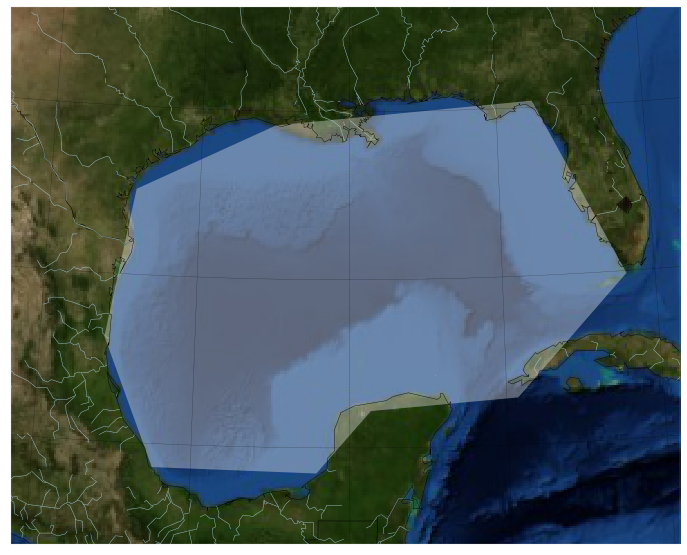

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

# Make a matplotlib figure:
plt.figure(figsize=(12, 12))

# Make basemap with AEAC projection and low-res features:
m = Basemap(
    projection = "aea", 
    resolution = "l",
    llcrnrlat  = min(lats) - 2.5,
    llcrnrlon  = min(lons) - 2.5,
    urcrnrlat  = max(lats) + 2.5,
    urcrnrlon  = max(lons) + 2.5,
    lat_0      = geocent[0], 
    lon_0      = geocent[1], 
)

# Add your preferred Basemap built-in layers,
m.bluemarble()
m.drawcountries()
m.drawrivers(color="lightblue", linewidth=0.4)
m.drawcoastlines(color="black", linewidth=0.4)
m.drawparallels(range(20, 35, 5), color="black", linewidth=0.3, alpha=0.05)
m.drawmeridians(range(-105, -75, 5), color="black", linewidth=0.3, alpha=0.05)
m.drawmapboundary(color="lightgray", linewidth=0.2)

# Convert geographic coordinates to map (i.e. plot) coordinates:
xs, ys = m(x=lons, y=lats)

# Zip back to a 2d array; create a matplotlib Polygon:
poly = Polygon(list(zip(xs, ys)), facecolor="white", alpha=0.35, linewidth=1.2)

# Then, add the polygon to the plot:
plt.gca().add_patch(poly)

Now we'll use Harmony API to get Sea Surface Temperature data from GHRSST in Albers Equal Area Conic (to match our input polygon). 

## Identify granules (CMR Search)

**We're going to try to do a simple workflow - one timestep at first, then a time series.**

1. Identify granules from `SOME TBD` collection that coincide with our input Gulf of Mexico polygon using the CMR Search API.
2. Use the Harmony API to process the first matching granule to a projected AEAC netCDF and download.
3. Mask the rectangular subset returned by the Harmony API with the Gulf of Mexico polygon.

Stretch goal is to process time series, aggregate over some interval.

This is the CMR Search query to retrieve the UMM record for the target collection:      
https://cmr.uat.earthdata.nasa.gov/search/collections.umm_json?native-id=C1234724470-POCLOUD&pretty=true

Make some generic functions in case we decide to do more queries later:

In [20]:
def _dumps(data: dict, indent: int=2, **kwargs):
    print(dumps(data, indent=indent, **kwargs))


def cmrsearch(end: str, uat: bool=True, **kwargs):
    """
    Returns a dictionary of CMR results for the input parameters.
    
    Parameters
    ----------
    end (str): search ('collections', 'granules', etc )
    uat (bool=True): Format the URL to the UAT CMR if True. 
    **kwargs: Supply query parameters as key, value pairs.
    
    Returns
    -------
    Dictionary representation of the 'umm_json' response.
    
    """
    # Insert an empty string if 'uat' is False.
    uatfmt = '.uat' if uat else ''
    
    # Format the search url with '.uat' if uat is True.
    search = f"https://cmr{uatfmt}.earthdata.nasa.gov/search"

    # Format the query parameters and values (kwargs) to a string:
    query = "&".join([f"{p}={v}" for p,v in kwargs.items()])
    
    # Download the data at the URL.
    response = request.urlopen(f"{search}/{end}.umm_json?{query}")
    
    # Decode, load the JSON string to a dict, return.
    return loads(response.read().decode())

### Collection

Get the collection record and display the `SpatialExtent` from its `umm` metadata:

In [21]:
cresults = cmrsearch('collections', **{'native-id': "MODIS_A-JPL-L2P-v2019.0"})
collection = cresults['items'][0]

_dumps(collection['umm']['SpatialExtent'])

{
  "SpatialCoverageType": "HORIZONTAL",
  "HorizontalSpatialDomain": {
    "Geometry": {
      "CoordinateSystem": "CARTESIAN",
      "BoundingRectangles": [
        {
          "WestBoundingCoordinate": -180.0,
          "NorthBoundingCoordinate": 90.0,
          "EastBoundingCoordinate": 180.0,
          "SouthBoundingCoordinate": -90.0
        }
      ]
    },
    "ResolutionAndCoordinateSystem": {
      "GeodeticModel": {
        "HorizontalDatumName": "World Geodetic System 1984",
        "EllipsoidName": "WGS 84",
        "SemiMajorAxis": 6378137,
        "DenominatorOfFlatteningRatio": 298.2572236
      }
    }
  },
  "GranuleSpatialRepresentation": "CARTESIAN"
}


Take a look at the info in the `ResolutionAndCoordinateSystem` field in `SpatialExtent`.

Knowing the "GeodeticModel", we can calculate optimal pixel sizes for our projected outputs (we'd also carefully consider the swath pixel resolutions, as calculated according to their offset from the nadir/orbit path).

We need the spatial extent of the source granule to really get it right, but we can calculate good sizes from the latitude longitude extent of our input polygon (also the extent of our output subset) and the info in `ResolutionAndCoordinateSystem`:

**TODO:** Calculate optimal projected pixel sizes for the output based on the lat/lon location and swath characteristics.

In [22]:
None

### Granules

We'll do a spatial search for all the granules with footprints overlapping our polygon. 

CMR Search supports spatial querying in a number of ways. The simplest method for our use case is to pass the vertices of the input polygon to the `polygon` parameter as a string of comma-separated X,Y values.

The list of geographic coordinates that we created in an earlier step (`geocrds`) gives each coordinate as a tuple like: `(LATY, LONX, ALTZ)`.

Use `numpy` to convert the list of tuples into a flat, comma-separated list of `LON,LAT,LON,LAT,...` . A few things to remember:

* Reverse the list of coordinates before flattening it (to comply with the API requirements for input polygons).
* Reverse Y,X (as returned by the transformation function applied above) to X,Y (as required by the `polygon` parameter of the CMR API).
* Eliminate all white spaces from the input string.

Flatten the list of geographic coordinates that we produced earlier, dropping the third item *Z* and reversing *Y,X* to *X,Y*:

In [23]:
fcrds = np.array([[c[1],c[0]] for c in geocrds])[::-1].flatten()

fcrds

array([-92.50277108,  29.56938225, -97.13008503,  27.53729917,
       -97.92333885,  23.11735526, -96.20462224,  19.29735788,
       -91.04847241,  19.23495552, -89.3297558 ,  21.09641925,
       -84.63633737,  21.40446734, -80.93448621,  24.92860973,
       -83.77697906,  30.1998377 , -92.50277108,  29.56938225])

Now join the flat array with commas `,` to match the format required for the CMR spatial query:

In [24]:
query_polygon = ",".join([str(round(v,4)) for v in fcrds])

query_polygon

'-92.5028,29.5694,-97.1301,27.5373,-97.9233,23.1174,-96.2046,19.2974,-91.0485,19.235,-89.3298,21.0964,-84.6363,21.4045,-80.9345,24.9286,-83.777,30.1998,-92.5028,29.5694'

Get CMR granules from collection `COLL TBD XYZ` that overlap our input polygon, and print the number of results (we pass the collection's `concept-id` to the granule search, rather than its `native-id`):

In [25]:
granules = cmrsearch('granules', **{
    'collection_concept_id': collection['meta']['concept-id'],
    'polygon': query_polygon,
    'page_size': 200,
})

granules['hits']

196

There are `196` in the target collection granules that overlap the spatial extent of our input vector dataset. 

Reformat the CMR Search (`meta`) and UMM (`umm`) metadata for the granules as two `pandas.DataFrame`s for convenient manipulation. Print the data for the first row (which corresponds to one granule record's CMR search metadata):

In [26]:
gmeta = DataFrame.from_records([r['meta'] for r in granules['items']])
gumm = DataFrame.from_records([r['umm'] for r in granules['items']])

gmeta.iloc[0].to_dict()

{'concept-type': 'granule',
 'concept-id': 'G1234724573-POCLOUD',
 'revision-id': 1,
 'native-id': '20200101074000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2020-05-14T23:51:12Z'}

**Get the time bounds of each granule as two new columns.**

This would be better if it has start and end time columns. Oh - they here, too:

```json
{
  "TemporalExtent": {
    "RangeDateTime": {
      "EndingDateTime": "2020-01-01T07:44:59.000Z",
      "BeginningDateTime": "2020-01-01T07:40:00.000Z"
```

Apply a lambda to select `BeginningDateTime`, `EndingDateTime` over the  `TemporalExtent` column of the UMM metadata table (`umm`) into two new columns in the search metadata table (`meta`):

In [27]:
T = gumm.TemporalExtent

# The format of the UMM record start and end times:
Tfmt = '%Y-%m-%dT%H:%M:%S.%fZ'

# Apply lambdas to select the start, end times from the UMM record:
for a in ['BeginningDateTime', 'EndingDateTime']: 
    gmeta[a] = T.apply(lambda x: datetime.strptime(x['RangeDateTime'][a], Tfmt))

gmeta.iloc[0].to_dict()

{'concept-type': 'granule',
 'concept-id': 'G1234724573-POCLOUD',
 'revision-id': 1,
 'native-id': '20200101074000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2020-05-14T23:51:12Z',
 'BeginningDateTime': Timestamp('2020-01-01 07:40:00'),
 'EndingDateTime': Timestamp('2020-01-01 07:44:59')}

**Now get the spatial bounds of all the granules (from `SpatialExtent`) as four new columns.**

This one is a little trickier. It's deeply nested:

```json
{
  "SpatialExtent": {
    "HorizontalSpatialDomain": {
      "Geometry": {
        "BoundingRectangles": [
          {
            "WestBoundingCoordinate": -100.303,
            "SouthBoundingCoordinate": 19.767,
            "EastBoundingCoordinate": -71.362,
            "NorthBoundingCoordinate": 40.999
          }
```

Make a function to return the four coordinates in a list in the same order as above.

In [28]:
def _gSpatialExtent(SpatialExtent: dict):
    
    # Loop through three nested depths, replacing SpatialExtent.
    for key in ['HorizontalSpatialDomain', 'Geometry', 'BoundingRectangles']:
        SpatialExtent = SpatialExtent[key]

    # Get value of each extent limit as a list and return (WSEN).
    return list([crd.values() for crd in SpatialExtent][0])


_gSpatialExtent(gumm.SpatialExtent.iloc[0])

[-100.303, 19.767, -71.362, 40.999]

Apply the function over the `SpatialExtent` column to make a 2d array of coordinates. Print the first five:

In [29]:
gSpatialExtent = np.array(gumm.SpatialExtent.apply(_gSpatialExtent).tolist())

gSpatialExtent[:5]

array([[-100.303,   19.767,  -71.362,   40.999],
       [-103.474,    2.054,  -78.16 ,   23.053],
       [-125.662,   15.841,  -97.881,   36.999],
       [ -90.537,    2.67 ,  -65.087,   23.627],
       [ -97.441,   20.361,  -68.234,   41.565]])

Tranpose the 2d array and add the four tall arrays to `gmeta` as columns, and display the space-time columns that'll be relevant to our next steps:

In [30]:
gmeta['West'], gmeta['South'], gmeta['East'], gmeta['North'] = gSpatialExtent.T.tolist()

# Display this selection of columns to avoid tall rows:
informative_columns = [
    'concept-type',
    'concept-id',
    'BeginningDateTime',
    'EndingDateTime',
    'West',
    'South',
    'East',
    'North',
]

gmeta[informative_columns]

,concept-type,concept-id,BeginningDateTime,EndingDateTime,West,South,East,North
0,granule,G1234724573-POCLOUD,2020-01-01 07:40:00,2020-01-01 07:44:59,-100.303,19.767,-71.362,40.999
1,granule,G1234724584-POCLOUD,2020-01-01 07:45:00,2020-01-01 07:49:59,-103.474,2.054,-78.160,23.053
2,granule,G1234724623-POCLOUD,2020-01-01 09:20:00,2020-01-01 09:24:59,-125.662,15.841,-97.881,36.999
3,granule,G1234724776-POCLOUD,2020-01-01 18:35:00,2020-01-01 18:39:59,-90.537,2.670,-65.087,23.627
4,granule,G1234724726-POCLOUD,2020-01-01 18:40:00,2020-01-01 18:44:59,-97.441,20.361,-68.234,41.565
...,...,...,...,...,...,...,...,...
191,granule,G1234734607-POCLOUD,2020-01-31 07:55:01,2020-01-31 07:59:59,-104.916,10.857,-78.235,31.943
192,granule,G1234734455-POCLOUD,2020-01-31 09:30:01,2020-01-31 09:34:58,-127.402,24.611,-96.647,45.873
193,granule,G1234734717-POCLOUD,2020-01-31 18:50:01,2020-01-31 18:54:57,-96.659,11.618,-69.897,32.582
194,granule,G1234734678-POCLOUD,2020-01-31 18:55:00,2020-01-31 18:59:57,-105.515,29.154,-72.642,50.512


Maybe do space-time coverages plot here, or something:

```python
gmeta.BeginningDateTime.dt.day.value_counts()
```

**The Harmony API also requires a `variable` input.**

See if the collection record lists any `associations` to CMR variables in its CMR search metadata.

In [31]:
"associations" in collection['meta']

False

No associations at all, bummer... 

Fortunately, we know this dataset's sea surface temperature variable to be `sea_surface_temperature` (which you can confirm by checking [the OPeNDAP landing page for another granule in the dataset](https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/MODIS_A/JPL/v2019.0/2006/033/20060202030506-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.html). 

For now, we'll get all variables by passing this parameter with our request: `variable=all`.

## Retrieve data (Harmony API)

The Harmony API usage that follows is shamelessly lifted from [Mike's UWG Demo notebook](https://github.com/podaac/tutorials/blob/master/notebooks/l2-regridding/reprojection%20notebook.md#access-level-2-swath-regridded-data)
(the `sds/swot-reproject` part).

Harmony API will call the necessary services to perform the reprojection from WGS84 (native) to AEAC (SRS of our input polygon), and delivers the output image as a CF-compliant netCDF.

### Assemble the request url

Now we're gonna prepare the url to request a subset of the first granule via the Harmony API L2 swath service. Here's the granule's search metadata:

In [32]:
gmeta.iloc[0]

concept-type                                                   granule
concept-id                                         G1234724573-POCLOUD
revision-id                                                          1
native-id            20200101074000-JPL-L2P_GHRSST-SSTskin-MODIS_A-...
provider-id                                                    POCLOUD
format                               application/vnd.nasa.cmr.umm+json
revision-date                                     2020-05-14T23:51:12Z
BeginningDateTime                                  2020-01-01 07:40:00
EndingDateTime                                     2020-01-01 07:44:59
West                                                          -100.303
South                                                           19.767
East                                                           -71.362
North                                                           40.999
Name: 0, dtype: object

These definitions will get better when I find more info about them.

>The Harmony API accepts several query parameters related to regridding and interpolation in addition to the reprojection parameters above:
>
>* `outputCrs`: a GDAL-supported projecction identifier, like EPSG, Proj, OGC WKT, etc.   
>* `interpolation`: one of ```('near', 'bilinear')```,
>* `scaleSize`: a comma-separated pair of floats giving `x,y` cell dimensions (?),
>* `scaleExtent`: four comma-separated floats giving `xmin,ymin,xmax,ymax`
>* `width`: (? output x dimension size, I think)
>* `height`: (? output y dimension size, I think)
>
>An error is returned if both `scaleSize` and `width`/`height` parameters are both provided (only one or the other can be used).

Albers Equal Area Conic for NA (`EPSG:102008`) is still our preferred output srs:

In [33]:
param = {
    'granuleid': gmeta.iloc[0]['concept-id'],
    'variable': 'all',
    'outputCrs': "EPSG:102008",
    'interpolation': "near",
}

param

{'granuleid': 'G1234724573-POCLOUD',
 'variable': 'all',
 'outputCrs': 'EPSG:102008',
 'interpolation': 'near'}

Join `param` twice into query string:

* Join parameters to values with `=`
* Join `parameter=value` strings together with `&`

In [34]:
query = "&".join([f"{p}={v}" for p, v in param.items() if v is not None])

query

'granuleid=G1234724573-POCLOUD&variable=all&outputCrs=EPSG:102008&interpolation=near'

Format service endpoint for the target collection:

In [35]:
# Target collection's 'concept-id' and the target variable:
conceptid = collection['meta']['concept-id']
variable = "all"

# Format the service endpoint:
end = f"{conceptid}/ogc-api-coverages/1.0.0/collections/{variable}/coverage/rangeset"

end

'C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset'

And append endpoint+parameters to Harmony API base url:

In [36]:
url = f"https://harmony.uat.earthdata.nasa.gov/{end}?{query}"

print(url)

https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G1234724573-POCLOUD&variable=all&outputCrs=EPSG:102008&interpolation=near


### Download, open in Python

Submit the subset request and wait for the response. Hope for `200`!

In [37]:
# Retrieve the data at the URL:
response = request.urlopen(url)

# Read the response data:
data = response.read()

response.status

200

#### with `netCDF4`

`netCDF4` will open the file without writing to disk. Open it, print its variables, then close it again:

In [38]:
ds = Dataset('name', mode="r", memory=data)
display(list(ds.variables))
ds.close()

['time',
 'sses_standard_deviation',
 'albers_conical_equal_area',
 'x',
 'y',
 'quality_level_4um',
 'sses_standard_deviation_4um',
 'sea_surface_temperature',
 'sses_bias_4um',
 'dt_analysis',
 'sst_dtime',
 'quality_level',
 'wind_speed',
 'sea_surface_temperature_4um',
 'sses_bias',
 'l2p_flags']

#### with `xarray`

You can also open the output data file object with `xarray` if you have `h5netcdf` (also developed by S. Hoyer at el., creators of `xarray`). You need to pass the file to `xarray.open_dataset` as an `io.BytesIO` object.


(These values aren't auto-scaling or auto-masking properly. I disable auto-mask here to allow us to proceed.)

In [39]:
from io import BytesIO
import xarray as xr

ds = xr.open_dataset(BytesIO(data), engine="h5netcdf", mask_and_scale=False)

list(ds.variables)

['time',
 'sses_standard_deviation',
 'albers_conical_equal_area',
 'x',
 'y',
 'quality_level_4um',
 'sses_standard_deviation_4um',
 'sea_surface_temperature',
 'sses_bias_4um',
 'dt_analysis',
 'sst_dtime',
 'quality_level',
 'wind_speed',
 'sea_surface_temperature_4um',
 'sses_bias',
 'l2p_flags']

Select the `sea_surface_temperature` variable like so:

In [40]:
sst = ds['sea_surface_temperature']

### Plot `sea_surface_temperature`

Plot `sea_surface_temperature` variable with its full range of values:

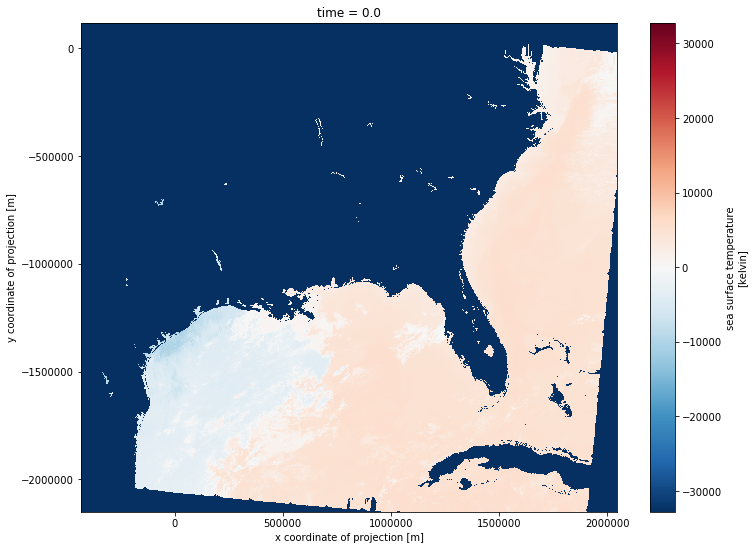

In [41]:
sst.plot(figsize=(12, 9))

Next, we'll limit the data coverage to the area within our polygon mask.

## Mask output SST variable

### Affine GeoTransform

To properly mask a projected output, we need to create a mask that matches its dimensions exactly. GDAL provides robust methods to do this.

The reprojection service called by the Harmony API includes a CF-required `grid_mapping` variable with our output. The variable doesn't contain any actual data, just standard projection parameters given as attributes. Read more about CF `grid_mapping` variable in the CF documentation at this anchor link:       
http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/build/apf.html

Here's the **list of attribute names for `albers_conical_equal_area`** ([CF-1.x standard variable and `grid_mapping_name`](#)) - a few of these are important for producing the mask:

In [42]:
grid_mapping = ds['albers_conical_equal_area']

list(grid_mapping.attrs.keys())

['grid_mapping_name',
 'false_easting',
 'false_northing',
 'latitude_of_projection_origin',
 'longitude_of_central_meridian',
 'standard_parallel',
 'long_name',
 'longitude_of_prime_meridian',
 'semi_major_axis',
 'inverse_flattening',
 'spatial_ref',
 'GeoTransform']

The `GeoTransform` attribute gives affine transform parameters in the format required by [GDAL's raster data model](https://gdal.org/user/raster_data_model.html#affine-geotransform):

```python
gt = ( 0  X minimum (upper-left corner, the origin),
       1  X resolution,
       2  X rotation,
       3  Y maximum (upper-left corner, the origin),
       4  Y rotation,
       5  Y resolution )
```

The geotransform tells GDAL how to position, rotate, and scale a gridded dataset in a coordinate system. We need some of this info (items: 0, 1, 3, 5) to make the mask grid that exactly matches the grid output by the reprojection service.

**Get the `GeoTransform` attribute** (a string) and split it by white spaces, dropping the trailing item if necessary. Then, convert the strings to **floats** and the list to **a tuple**:

In [43]:
gt = tuple([float(t) for t in grid_mapping.GeoTransform.split(" ")[:6]])

gt

(-431759.948219411,
 1312.456748943353,
 0.0,
 119456.4002972631,
 0.0,
 -1312.456748943353)

The reprojection service also includes the OGC Well Known Text (WKT) crs reference in the `spatial_ref` attribute of the `grid_mapping` variable (`albers_conical_equal_area`, in this case):

In [44]:
wkt = grid_mapping.spatial_ref

wkt

'PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",60],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'

We'll use both the geotransform `gt` and the spatial reference system's WKT string `wkt` as inputs to produce the mask.

### Rasterize polygon to mask

Now, let's use GDAL to make an empty raster with the same spatial coverage as the returned dataset, then rasterize our input Gulf of Mexico polygon within that grid.

We need to create the new raster with column and row counts that match our gridded output from the Harmony API:

In [45]:
ds.x.size, ds.y.size

(1887, 1730)

Create an empty raster dataset in memory `mask0`. Match the dimensions of the output dataset:

In [46]:
mask0 = gdal.GetDriverByName('MEM').Create(
    '',                 # No filename required for memory dataset.
    ds.x.size,          # Copy the number of cols in the output.
    ds.y.size,          # Do the same for rows.
    1,                  # Mask should have only one band.
    gdal.GDT_Byte,      # Output type is byte (0, 1).
)

Select band one of the empty raster dataset, fill it with zeros, and set its nodata value to zero:

In [47]:
band = mask0.GetRasterBand(1)
band.Fill(0)
band.SetNoDataValue(0)

0

Set the GeoTransform (`gt`) and the WKT (`wkt`) from the output dataset to the corresponding attributes of the new raster dataset:

In [48]:
mask0.SetGeoTransform(gt)
mask0.SetProjection(wkt)

0

Finally, rasterize the original input polygon layer (`lyr`) to the new grid (`mask0`), replacing zeros with ones for pixels/cells within the polygon coverage area:

In [49]:
err = gdal.RasterizeLayer(
    mask0,               # The new mask raster dataset.
    [1],                 # We will replace values in band 1 only.
    lyr,                 # This is the original input vector layer.
    burn_values=[1],     # Polygon coverage area is filled with 1s.
)

mask0.FlushCache()       # "Write" changes to in-memory dataset.

Get the new mask's array and display it:

In [50]:
mask0arr = mask0.GetRasterBand(1).ReadAsArray()

mask0arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

That doesn't help.

In [51]:
print(f"INSIDE  (1):\t{np.count_nonzero(mask0arr==1.)}")
print(f"OUTSIDE (0):\t{np.count_nonzero(mask0arr==0.)}")

INSIDE  (1):	793502
OUTSIDE (0):	2471008


### Add mask to output dataset

We can add the mask to the output dataset as a new `xarray.DataArray` because it perfectly matches the spatial coverage.

Create a new `xarray.DataArray` and add it to the dataset that we opened from the Harmony API output. And add some CF-standard attributes to describe the new mask variable.

**NOTE: Don't forget to flip the mask on its Y-axis!** 

The netCDF dataset output by Harmony API has its origin at the lower-left corner, while the mask generated with GDAL has its origin in the upper-left corner. You can use the `numpy` convenience function `numpy.flipud` to invert the raster on its y-axis.

In [52]:
ds['mask'] = xr.DataArray(

    # Invert mask array on its y axis before assigning mask data.
    np.flipud(mask0arr),  
    
    # The mask array shares dimensions of the output SST dataset.
    coords=[ds.y, ds.x],
    dims=['y', 'x'],
    
    # Set the appropriate CF attributes to the mask variable.
    attrs = {
        'grid_mapping': "albers_conical_equal_area",
        'flag_values': (0, 1),
        'flag_meanings': "nodata data",
        '_FillValue':0,
    }

)

ds.mask.attrs

{'grid_mapping': 'albers_conical_equal_area',
 'flag_values': (0, 1),
 'flag_meanings': 'nodata data',
 '_FillValue': 0}

Plot the mask and the data side-by-side to eye-test the coverage of the new mask:

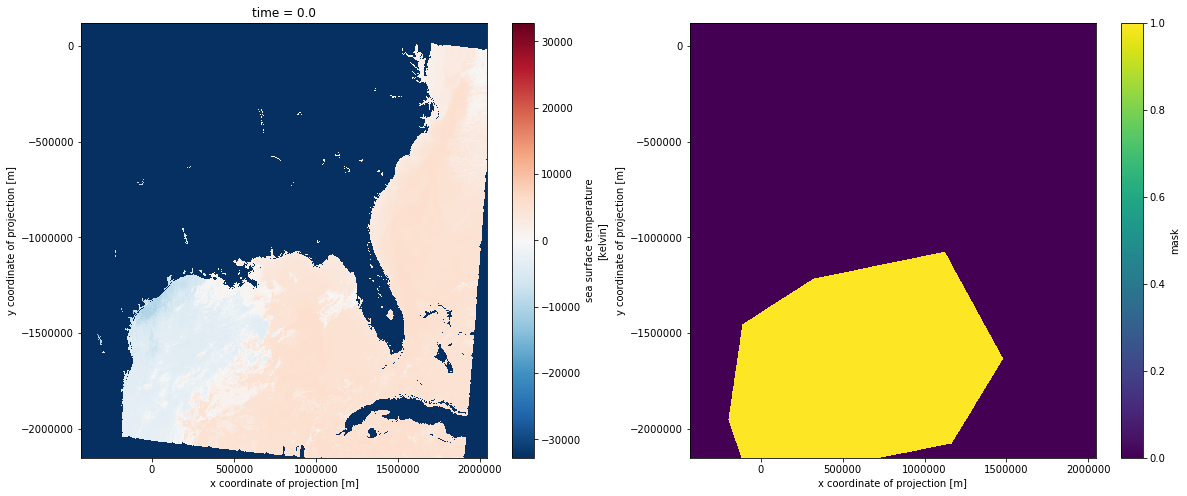

In [53]:
fig, axes = plt.subplots(figsize=(20, 8), ncols=2)
sst.plot(ax=axes[0])         # Plot SST on axis 0.
ds.mask.plot(ax=axes[1])     #  and plot the mask on axis 1.

I think this passes the eye test. The input polygon's coverage is roughly the same as the Gulf of Mexico. 

### Apply the mask

Apply the mask and plot the result. Use the `numpy.where` function (inherited by the `xarray.DataArray` class) to set areas where the `ds.mask` equals zero to the fill value of the SST variable (`sst._FillValue`):

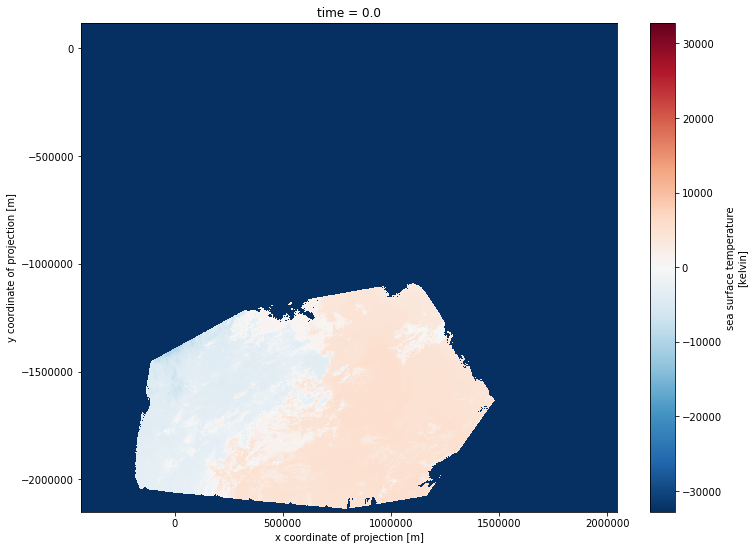

In [54]:
ds['masked_sst'] = sst.where(ds.mask==1, sst._FillValue)

ds.masked_sst.plot(figsize=(12, 9))

Finally, mask and scale the still-cf-encoded data with `xr.decode_cf` and plot it:

In [ ]:
ds = xr.decode_cf(ds, mask_and_scale=True)

ds.masked_sst.plot(figsize=(12, 9))

Bada-bing, bada-boom. There's a masked output from the Harmony API reprojection service. 

In the next section, we'll download a time series of reprojected granules overlapping our input polygon and apply this same routine to each timestep.

## Process a series (`WIP`) 

**This section is a work in progress.**

Now, let's do that same routine for a series of granules returned by our earlier CMR search.

There are plenty of tiles that barely overlap our polygon of the Gulf of Mexico. Those aren't worth our time, so select from the table the granules with extents containing the centroid of our polygon:

In [ ]:
centroid_selection = gmeta.apply(lambda x: all([
    x.West < geocent[1],
    x.South < geocent[0],
    x.East > geocent[1],
    x.North > geocent[0],
]), 1)

centroid_selection.describe()

That reduces the total granules to process quite a bit:

In [ ]:
gmeta_short = gmeta[centroid_selection]

gmeta_short.index.size

Get the `informative_columns` of the table selection `gmeta_short`:

In [ ]:
gmeta_short[informative_columns]

And here's the complete routine carelessly packaged into two functions so you can run in a batch:

```python
def get_the_data(granuleid: str):
    
    # Make a new dictionary of parameters.
    param = {
        'granuleid': granuleid,
        'variable': 'all',
        'outputCrs': "EPSG:102008",
        'interpolation': "near",
        'scaleSize': f"{1000},{1000}",
        'scaleExtent': f"{1000},{1000}",
    }
    
    # Join the query string again.
    query = "&".join([f"{p}={v}" for p, v in param.items() if v is not None])

    # Construct the URL for the current granule.
    url = f"https://harmony.uat.earthdata.nasa.gov/{end}?{query}"

    # Retrieve the data at the URL:
    response = request.urlopen(url)
    
    # Read the response data:
    data = response.read()
    
    # Open and return the dataset.
    ds = xr.open_dataset(BytesIO(data), engine="h5netcdf", mask_and_scale=False)
    
    return ds
    

def get_the_mask(dataset):

    # Create a new GDAL raster dataset in memory.
    mask = gdal.GetDriverByName('MEM').Create(
        '', dataset.x.size, dataset.y.size, 1, gdal.GDT_Byte)

    # Fill all cells in band 1 with zeros, set band 1 nodata value to zero.
    band = mask.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    # Get the grid_mapping variable from the input dataset.
    grid = dataset['albers_conical_equal_area']
    
    # Get its GeoTransform attribute as a tuple of floats.
    gt = tuple([float(t) for t in grid.GeoTransform.split(" ")[:6]])
    
    # Set the mask dataset's geotransform and projection.
    mask.SetGeoTransform(gt)
    mask.SetProjection(grid.spatial_ref)

    # Rasterize the input polygon to the new matching grid (AEAC):
    err = gdal.RasterizeLayer(mask, [1], lyr, burn_values=[1])
    mask.FlushCache()       

    # Get the mask array. Close the mask dataset.
    maskarr = mask.GetRasterBand(1).ReadAsArray()
    mask = None
    
    # Create and return a mask DataArray.
    return xr.DataArray(

        # Invert mask array on its y axis before assigning mask data.
        np.flipud(maskarr),  

        # The mask array shares dimensions of the output SST dataset.
        coords=[dataset.y, dataset.x],
        dims=['y', 'x'],

        # Set the appropriate CF attributes to the mask variable.
        attrs = {
            'grid_mapping': "albers_conical_equal_area",
            'flag_values': (0, 1),
            'flag_meanings': "nodata data",
            '_FillValue':0,
        }

    )

```